# DF/DN on CC18

In [1]:
# Import required packages
import numpy as np
import matplotlib as mpl
from matplotlib.ticker import NullFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
import openml

In [2]:
# Define color palette
sns.set(color_codes=True, style="white", context="talk", font_scale=1.5)

In [3]:
def load_result(filename):
    """
    Loads results from specified file
    """
    return np.loadtxt(filename)


def read_params_txt(filename):
    """
    Read in tuned hyperparameters from text file
    """
    params = []
    f = open(filename, "r").read()
    f = f.split("\n")
    f = f[:-1]
    for ind, i in enumerate(f):
        temp = ast.literal_eval(f[ind])
        params.append(temp)
    return params


def load_cc18():
    """
    Import datasets from OpenML-CC18 dataset suite
    """
    X_data_list = []
    y_data_list = []
    dataset_name = []

    for data_id in openml.study.get_suite("OpenML-CC18").data:
        try:
            successfully_loaded = True
            dataset = openml.datasets.get_dataset(data_id)
            dataset_name.append(dataset.name)
            X, y, is_categorical, _ = dataset.get_data(
                dataset_format="array", target=dataset.default_target_attribute
            )
            _, y = np.unique(y, return_inverse=True)
            X = np.nan_to_num(X)
        except TypeError:
            successfully_loaded = False
        if successfully_loaded and np.shape(X)[1] > 0:
            X_data_list.append(X)
            y_data_list.append(y)

    return X_data_list, y_data_list, dataset_name

In [4]:
directory = "../benchmarks/tabular/"

# Load model performances across range of sample sizes
all_rf_kappa = load_result(directory + "results/cc18_rf_kappa.txt")
all_dn_kappa = load_result(directory + "results/cc18_dn_kappa.txt")
all_rf_ece = load_result(directory + "results/cc18_rf_ece.txt")
all_dn_ece = load_result(directory + "results/cc18_dn_ece.txt")

# Load model wall times
rf_times_train = load_result(directory + "results/cc18_rf_times_train.txt")
rf_times_test = load_result(directory + "results/cc18_rf_times_test.txt")
dn_times_train = load_result(directory + "results/cc18_dn_times_train.txt")
dn_times_test = load_result(directory + "results/cc18_dn_times_test.txt")

# Load sample sizes per dataset
all_sample_sizes = load_result(directory + "metrics/cc18_sample_sizes.txt")

## DF/DN Comparison Figure

- Panel 1 visualizes the change in Cohen's Kappa of each model for each dataset. 

- Panel 2 visualizes the change in ECE of each model for each dataset. 

- Panel 3 visualizes the training wall times of each model for each dataset. 

In the first two figures, the thick lines represent the interpolated mean. In the last figure, the thick lines represent the interpolated medians. Shaded regions represent the 25th through 75th quartiles.

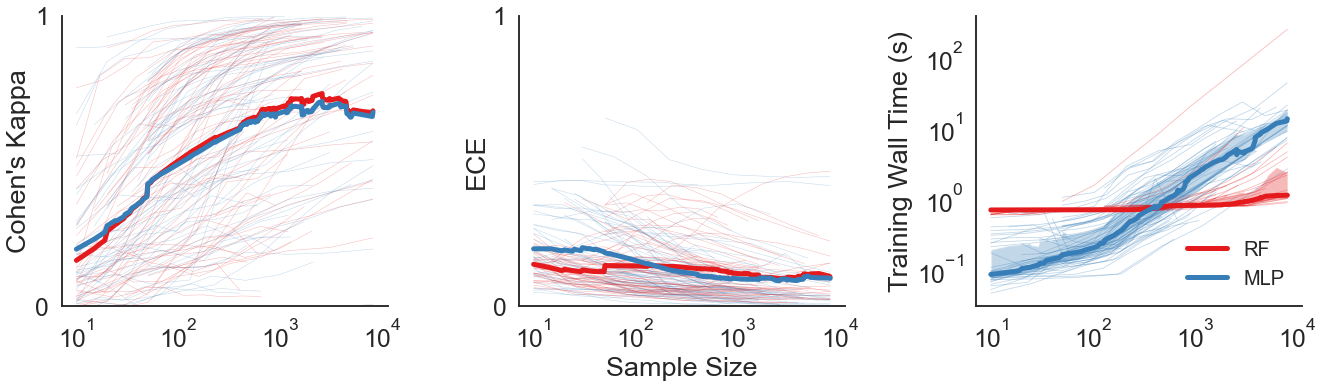

In [5]:
fig = plt.figure(figsize=(19, 6))

# Subplot 1 - Cohen's Kappa
ax = plt.subplot(131)

samples = list(np.sort(np.unique(all_sample_sizes)))

rf_kappa_over_dataset = []
dn_kappa_over_dataset = []

total_sets = all_rf_kappa.shape[0] / 8
rf_kappa = np.zeros((int(total_sets), 8))
dn_kappa = np.zeros((int(total_sets), 8))

for dataset in range(int(total_sets)):
    rf = all_rf_kappa[dataset * 8 : dataset * 8 + 8, :]
    dn = all_dn_kappa[dataset * 8 : dataset * 8 + 8, :]

    rf_evolution_mean = np.mean(rf, axis=1)
    dn_evolution_mean = np.mean(dn, axis=1)

    rf_kappa[dataset, :] = rf_evolution_mean
    dn_kappa[dataset, :] = dn_evolution_mean

    # Interpolate RF Kappa
    sample_ = list(all_sample_sizes[dataset, :])
    interp_func_kappa = interp1d(all_sample_sizes[dataset], rf_kappa[dataset, :])
    interpolated_kappa = np.array([np.nan] * len(samples))
    interpolated_kappa_ = interp_func_kappa(
        np.array(samples)[
            np.where((samples >= sample_[0]) & (samples <= sample_[-1]))[0]
        ]
    )
    interpolated_kappa[
        np.where((samples >= sample_[0]) & (samples <= sample_[-1]))[0]
    ] = interpolated_kappa_
    rf_kappa_over_dataset.append(interpolated_kappa)

    # Interpolate MLP Kappa
    interp_func_kappa = interp1d(all_sample_sizes[dataset], dn_kappa[dataset, :])
    interpolated_kappa = np.array([np.nan] * len(samples))
    interpolated_kappa_ = interp_func_kappa(
        np.array(samples)[
            np.where((samples >= sample_[0]) & (samples <= sample_[-1]))[0]
        ]
    )
    interpolated_kappa[
        np.where((samples >= sample_[0]) & (samples <= sample_[-1]))[0]
    ] = interpolated_kappa_
    dn_kappa_over_dataset.append(interpolated_kappa)

for dataset in range(int(total_sets)):
    ax.plot(
        all_sample_sizes[dataset],
        rf_kappa[dataset, :],
        c="#e41a1c",
        alpha=0.3,
        lw=0.5,
    )
    ax.plot(
        all_sample_sizes[dataset],
        dn_kappa[dataset, :],
        c="#377eb8",
        alpha=0.3,
        lw=0.5,
    )

ax.set_ylabel("Cohen's Kappa")
ax.set_xscale("log")
ax.set_ylim([0, 1])
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

ax.plot(samples, np.nanmean(rf_kappa_over_dataset, axis=0), c="#e41a1c", lw=5)
ax.plot(samples, np.nanmean(dn_kappa_over_dataset, axis=0), c="#377eb8", lw=5)

plt.yticks([0, 1])
plt.xticks([1e1, 1e2, 1e3, 1e4])


# Subplot 2 - ECE
ax = plt.subplot(132)

rf_ece_over_dataset = []
dn_ece_over_dataset = []

total_sets = all_rf_ece.shape[0] / 8
rf_ece = np.zeros((int(total_sets), 8))
dn_ece = np.zeros((int(total_sets), 8))

for dataset in range(int(total_sets)):
    rf = all_rf_ece[dataset * 8 : dataset * 8 + 8, :]
    dn = all_dn_ece[dataset * 8 : dataset * 8 + 8, :]

    rf_evolution_mean = np.mean(rf, axis=1)
    dn_evolution_mean = np.mean(dn, axis=1)

    rf_ece[dataset, :] = rf_evolution_mean
    dn_ece[dataset, :] = dn_evolution_mean

    # Interpolate RF ECE
    sample_ = list(all_sample_sizes[dataset, :])
    interp_func_ece = interp1d(all_sample_sizes[dataset], rf_ece[dataset, :])
    interpolated_ece = np.array([np.nan] * len(samples))
    interpolated_ece_ = interp_func_ece(
        np.array(samples)[
            np.where((samples >= sample_[0]) & (samples <= sample_[-1]))[0]
        ]
    )
    interpolated_ece[
        np.where((samples >= sample_[0]) & (samples <= sample_[-1]))[0]
    ] = interpolated_ece_
    rf_ece_over_dataset.append(interpolated_ece)

    # Interpolate MLP ECE
    interp_func_ece = interp1d(all_sample_sizes[dataset], dn_ece[dataset, :])
    interpolated_ece = np.array([np.nan] * len(samples))
    interpolated_ece_ = interp_func_ece(
        np.array(samples)[
            np.where((samples >= sample_[0]) & (samples <= sample_[-1]))[0]
        ]
    )
    interpolated_ece[
        np.where((samples >= sample_[0]) & (samples <= sample_[-1]))[0]
    ] = interpolated_ece_
    dn_ece_over_dataset.append(interpolated_ece)

for dataset in range(int(total_sets)):
    ax.plot(
        all_sample_sizes[dataset],
        rf_ece[dataset, :],
        c="#e41a1c",
        alpha=0.3,
        lw=0.5,
    )
    ax.plot(
        all_sample_sizes[dataset],
        dn_ece[dataset, :],
        c="#377eb8",
        alpha=0.3,
        lw=0.5,
    )

ax.set_xlabel("Sample Size")
ax.set_ylabel("ECE")
ax.set_xscale("log")
ax.set_ylim([0, 1])
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)


ax.plot(samples, np.nanmean(rf_ece_over_dataset, axis=0), c="#e41a1c", lw=5)
ax.plot(samples, np.nanmean(dn_ece_over_dataset, axis=0), c="#377eb8", lw=5)

plt.yticks([0, 1])
plt.xticks([1e1, 1e2, 1e3, 1e4])


# Subplot 3 - Training Wall Time
ax = plt.subplot(133)

times_over_dataset_rf = []
times_over_dataset_dn = []

total_sets = rf_times_train.shape[0] / 8
rf_times_tot = np.zeros((int(total_sets), 8))
dn_times_tot = np.zeros((int(total_sets), 8))

for dataset in range(int(total_sets)):
    rf = rf_times_train[dataset * 8 : dataset * 8 + 8, :]
    dn = dn_times_train[dataset * 8 : dataset * 8 + 8, :]

    dn_times_mean = np.median(dn, axis=1)
    rf_times_mean = np.median(rf, axis=1)

    dn_times_tot[dataset, :] = dn_times_mean
    rf_times_tot[dataset, :] = rf_times_mean

    # Interpolate RF Time
    sample_ = list(all_sample_sizes[dataset, :])
    interp_func_time = interp1d(all_sample_sizes[dataset], rf_times_tot[dataset, :])
    interpolated_time = np.array([np.nan] * len(samples))
    interpolated_time_ = interp_func_time(
        np.array(samples)[
            np.where((samples >= sample_[0]) & (samples <= sample_[-1]))[0]
        ]
    )
    interpolated_time[
        np.where((samples >= sample_[0]) & (samples <= sample_[-1]))[0]
    ] = interpolated_time_
    times_over_dataset_rf.append(interpolated_time)

    # Interpolate MLP Time
    interp_func_time = interp1d(all_sample_sizes[dataset], dn_times_tot[dataset, :])
    interpolated_time = np.array([np.nan] * len(samples))
    interpolated_time_ = interp_func_time(
        np.array(samples)[
            np.where((samples >= sample_[0]) & (samples <= sample_[-1]))[0]
        ]
    )
    interpolated_time[
        np.where((samples >= sample_[0]) & (samples <= sample_[-1]))[0]
    ] = interpolated_time_
    times_over_dataset_dn.append(interpolated_time)


for dataset in range(int(total_sets)):
    ax.plot(
        all_sample_sizes[dataset],
        rf_times_tot[dataset, :],
        c="#e41a1c",
        alpha=0.3,
        lw=0.8,
    )
    ax.plot(
        all_sample_sizes[dataset],
        dn_times_tot[dataset, :],
        c="#377eb8",
        alpha=0.3,
        lw=0.8,
    )

ax.set_ylabel("Training Wall Time (s)")
ax.set_xscale("log")
ax.set_yscale("log")
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)


qunatiles = np.nanquantile(times_over_dataset_rf, [0.25, 0.75], axis=0)
ax.fill_between(samples, qunatiles[0], qunatiles[1], facecolor="#e41a1c", alpha=0.3)
ax.plot(
    samples,
    np.nanmedian(times_over_dataset_rf, axis=0),
    c="#e41a1c",
    lw=5,
    label="RF",
)

qunatiles = np.nanquantile(times_over_dataset_dn, [0.25, 0.75], axis=0)
ax.fill_between(samples, qunatiles[0], qunatiles[1], facecolor="#377eb8", alpha=0.3)
ax.plot(
    samples,
    np.nanmedian(times_over_dataset_dn, axis=0),
    c="#377eb8",
    lw=5,
    label="MLP",
)

ax.legend(fontsize=20, loc="lower right", frameon=False)
plt.tight_layout()
plt.xticks([1e1, 1e2, 1e3, 1e4])
plt.savefig("../paper/figures/cc18.pdf", transparent=True, bbox_inches="tight")

## DF/DN Scatter Plot

- Column 1 visualizes the relationship between kappa and features for both models. 

- Column 2 visualizes the relationship between train time and features for both models. 

- Column 3 visualizes the relationship between test time and features for both models. 

- Column 4 visualizes the relationship between kappa and number of classes for both models.

Each row represents a bin grouping a certain number of samples. Treadlines for RF and DN models are plotted using linear regression.

In [5]:
# Load in data on dataset classes and dimensions
X_data_list, y_data_list, dataset_name = load_cc18()

dimensions = np.zeros(576)
classes = np.zeros(576)
for i in range(len(X_data_list)):
    dimensions[i * 8 : i * 8 + 8] = X_data_list[i].shape[1]
    classes[i * 8 : i * 8 + 8] = len(np.unique(y_data_list[i]))

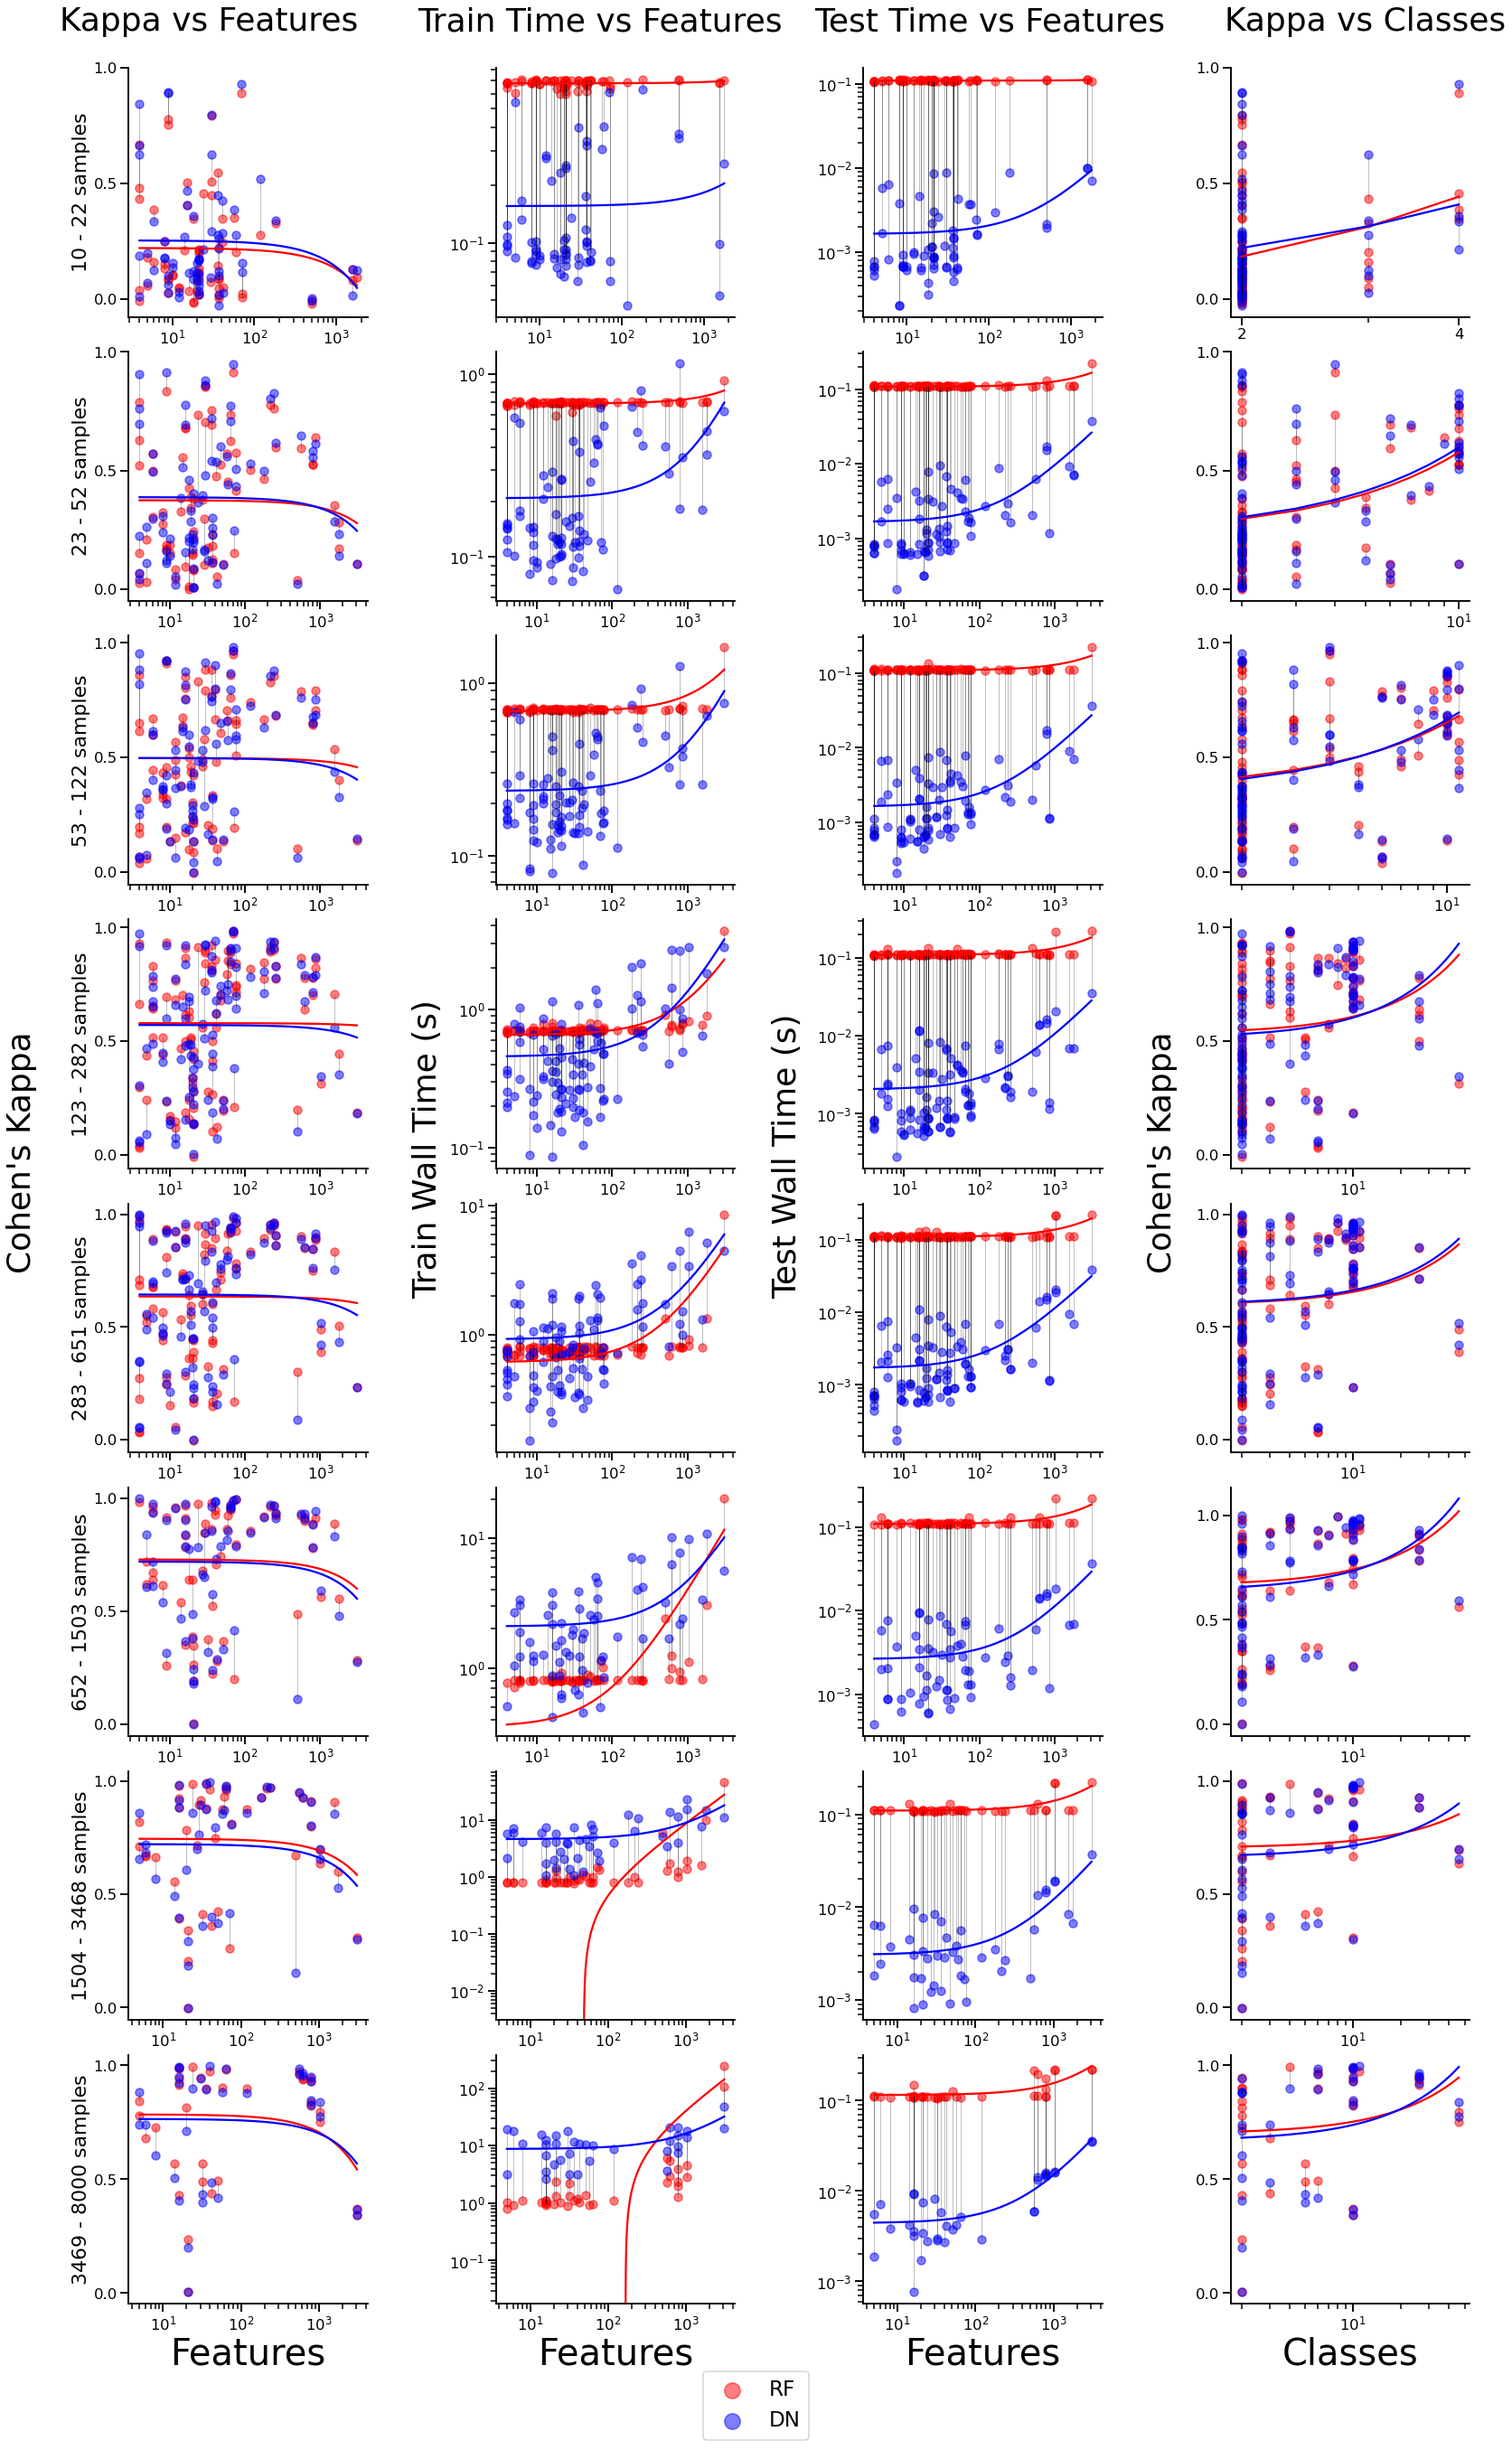

In [6]:
# Set color palette
sns.set_context("talk")
fig, ax = plt.subplots(nrows=8, ncols=3, sharex=True, sharey=True, figsize=(24, 38))

# Set bins to group sample sizes
baskets = [10, 23, 53, 123, 283, 652, 1504, 3469, 8001]

ordered_sample_sizes = full_dataset_all_sample_sizes.reshape(576)

# Average data across runs and index into arrays
scaled_rf_kappa = np.zeros((576, 2))
scaled_dn_kappa = np.zeros((576, 2))
scaled_rf_time_train = np.zeros((576, 2))
scaled_dn_time_train = np.zeros((576, 2))
scaled_rf_time_test = np.zeros((576, 2))
scaled_dn_time_test = np.zeros((576, 2))

for i, key in enumerate(ordered_sample_sizes):
    scaled_rf_kappa[i, :] = [key, np.mean(full_dataset_rf_scores_kappa[i])]
    scaled_dn_kappa[i, :] = [key, np.mean(full_dataset_dn_scores_kappa[i])]
    scaled_rf_time_train[i, :] = [key, np.mean(rf_times_train[i])]
    scaled_dn_time_train[i, :] = [key, np.mean(dn_times_train[i])]
    scaled_rf_time_test[i, :] = [key, np.mean(rf_times_test[i])]
    scaled_dn_time_test[i, :] = [key, np.mean(dn_times_test[i])]


# Generate figure
for plot in range(8):
    runs = np.where(
        (scaled_rf_kappa[:, 0] >= baskets[plot])
        & (scaled_rf_kappa[:, 0] < baskets[plot + 1])
    )
    rf = scaled_rf_kappa[runs][:, 1]
    dn = scaled_dn_kappa[runs][:, 1]
    rft_train = scaled_rf_time_train[runs][:, 1]
    dnt_train = scaled_dn_time_train[runs][:, 1]
    rft_test = scaled_rf_time_test[runs][:, 1]
    dnt_test = scaled_dn_time_test[runs][:, 1]
    dim = dimensions[runs]
    clas = classes[runs]

    # Subplot column 1
    ax = plt.subplot(8, 4, plot * 4 + 1)

    plt.scatter(dim, rf, c="r", alpha=0.5, label="RF")
    plt.scatter(dim, dn, c="b", alpha=0.5, label="DN")

    for ind in range(len(rf)):
        plt.plot([dim[ind], dim[ind]], [rf[ind], dn[ind]], lw=0.5, c="black", alpha=0.5)

    x_int_max = int(max(dim))
    x_int_min = int(min(dim))

    coeffs = np.polyfit(dim, rf, deg=1)
    x_ints = [i for i in range(x_int_min, x_int_max + 1)]
    predict = np.poly1d(coeffs)
    y_ints = predict(x_ints)
    plt.plot(x_ints, y_ints, c="r")

    coeffs = np.polyfit(dim, dn, deg=1)
    x_ints = [i for i in range(x_int_min, x_int_max + 1)]
    predict = np.poly1d(coeffs)
    y_ints = predict(x_ints)
    plt.plot(x_ints, y_ints, c="b")

    ax.set_ylabel(
        "{} - {} samples".format(baskets[plot], baskets[plot + 1] - 1), fontsize=22
    )

    if plot == 7:
        ax.set_xlabel("Features", fontsize=40)
    ax.set_xscale("log")
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)
    ax.set_yticks([0, 0.5, 1.0])

    # Subplot column 2
    ax2 = plt.subplot(8, 4, plot * 4 + 2)

    plt.scatter(dim, rft_train, c="r", alpha=0.5, label="RF")
    plt.scatter(dim, dnt_train, c="b", alpha=0.5, label="DN")

    for ind in range(len(rft_train)):
        plt.plot(
            [dim[ind], dim[ind]],
            [rft_train[ind], dnt_train[ind]],
            lw=0.5,
            c="black",
            alpha=0.5,
        )

    x_int_max = int(max(dim))
    x_int_min = int(min(dim))

    coeffs = np.polyfit(dim, rft_train, deg=1)
    x_ints = [i for i in range(x_int_min, x_int_max + 1)]
    predict = np.poly1d(coeffs)
    y_ints = predict(x_ints)
    plt.plot(x_ints, y_ints, c="r")

    coeffs = np.polyfit(dim, dnt_train, deg=1)
    x_ints = [i for i in range(x_int_min, x_int_max + 1)]
    predict = np.poly1d(coeffs)
    y_ints = predict(x_ints)
    plt.plot(x_ints, y_ints, c="b")

    if plot == 7:
        ax2.set_xlabel("Features", fontsize=40)
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    right_side = ax2.spines["right"]
    right_side.set_visible(False)
    top_side = ax2.spines["top"]
    top_side.set_visible(False)

    # Subplot column 3
    ax2 = plt.subplot(8, 4, plot * 4 + 3)

    plt.scatter(dim, rft_test, c="r", alpha=0.5, label="RF")
    plt.scatter(dim, dnt_test, c="b", alpha=0.5, label="DN")

    for ind in range(len(rft_train)):
        plt.plot(
            [dim[ind], dim[ind]],
            [rft_test[ind], dnt_test[ind]],
            lw=0.5,
            c="black",
            alpha=0.5,
        )

    x_int_max = int(max(dim))
    x_int_min = int(min(dim))

    coeffs = np.polyfit(dim, rft_test, deg=1)
    x_ints = [i for i in range(x_int_min, x_int_max + 1)]
    predict = np.poly1d(coeffs)
    y_ints = predict(x_ints)
    plt.plot(x_ints, y_ints, c="r")

    coeffs = np.polyfit(dim, dnt_test, deg=1)
    x_ints = [i for i in range(x_int_min, x_int_max + 1)]
    predict = np.poly1d(coeffs)
    y_ints = predict(x_ints)
    plt.plot(x_ints, y_ints, c="b")

    if plot == 7:
        ax2.set_xlabel("Features", fontsize=40)
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    right_side = ax2.spines["right"]
    right_side.set_visible(False)
    top_side = ax2.spines["top"]
    top_side.set_visible(False)

    # Subplot column 4
    ax = plt.subplot(8, 4, plot * 4 + 4)

    plt.scatter(clas, rf, c="r", alpha=0.5, label="RF")
    plt.scatter(clas, dn, c="b", alpha=0.5, label="DN")

    for ind in range(len(rft_train)):
        plt.plot(
            [clas[ind], clas[ind]], [rf[ind], dn[ind]], lw=0.5, c="black", alpha=0.5
        )

    x_int_max = int(max(clas))
    x_int_min = int(min(clas))

    coeffs = np.polyfit(clas, rf, deg=1)
    x_ints = [i for i in range(x_int_min, x_int_max + 1)]
    predict = np.poly1d(coeffs)
    y_ints = predict(x_ints)
    plt.plot(x_ints, y_ints, c="r")

    coeffs = np.polyfit(clas, dn, deg=1)
    x_ints = [i for i in range(x_int_min, x_int_max + 1)]
    predict = np.poly1d(coeffs)
    y_ints = predict(x_ints)
    plt.plot(x_ints, y_ints, c="b")

    ax.set_xscale("log")
    if plot == 0:
        ax.set_xticks([2, 4])
        ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        ax.xaxis.set_minor_formatter(NullFormatter())
    if plot == 1:
        ax.xaxis.set_minor_formatter(NullFormatter())
    if plot == 2:
        ax.xaxis.set_minor_formatter(NullFormatter())
    if plot == 7:
        ax.set_xlabel("Classes", fontsize=40)

    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)
    ax.set_yticks([0, 0.5, 1.0])


fig.text(0.02, 0.48, "Cohen's Kappa", ha="center", fontsize=36, rotation="vertical")
fig.text(
    0.28, 0.47, "Train Wall Time (s)", ha="center", fontsize=36, rotation="vertical"
)
fig.text(
    0.51, 0.47, "Test Wall Time (s)", ha="center", fontsize=36, rotation="vertical"
)
fig.text(0.75, 0.48, "Cohen's Kappa", ha="center", fontsize=36, rotation="vertical")

fig.text(0.14, 0.98, "Kappa vs Features", ha="center", fontsize=36)
fig.text(0.39, 0.98, "Train Time vs Features", ha="center", fontsize=36)
fig.text(0.64, 0.98, "Test Time vs Features", ha="center", fontsize=36)
fig.text(0.88, 0.98, "Kappa vs Classes", ha="center", fontsize=36)

handles, labels = ax.get_legend_handles_labels()
lgnd = fig.legend(handles, labels, loc="lower center", fontsize=23)
lgnd.legendHandles[0]._sizes = [300]
lgnd.legendHandles[1]._sizes = [300]

plt.tight_layout(pad=5, w_pad=5, h_pad=0)